# Sequentially Testing the Exchangeability of Stock Price Parity

In [1]:
import numpy as np
import pandas as pd
import datetime

import matplotlib as mpl
import seaborn as sns
import os

import ecombine as ec

In [2]:
# basic figure styles
ec.set_theme()

# rng for (randomized) inference methods
rng = np.random.default_rng(20241230)

# plots saved here
plots_dir = "./plots/stock_parity"
os.makedirs(plots_dir, exist_ok=True)
mpl.rc("savefig", format="pdf", dpi=350)

colors = sns.color_palette("colorblind")

In [3]:
START_DATE = '2018-01-01'
END_DATE = '2023-01-01'

START_YEAR = datetime.datetime.strptime(START_DATE, '%Y-%m-%d').year
END_YEAR = datetime.datetime.strptime(END_DATE, '%Y-%m-%d').year

DATA_DIR = f'./data/stock_parity_{START_YEAR}_{END_YEAR}/'
os.makedirs(DATA_DIR, exist_ok=True)

In [4]:
stock_tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'NVDA', 'TSLA', 'NKE',
    # s&p 500
    '^GSPC',
    # 10 year treasury bond
    '^TNX',
    ]
fx_tickers = [    
    'USDEUR=X', 'USDJPY=X', 'USDCNY=X',
]
tickers = stock_tickers + fx_tickers

## Sequentially test exchangeability of parity sequences for each ticker

[*********************100%***********************]  1 of 1 completed


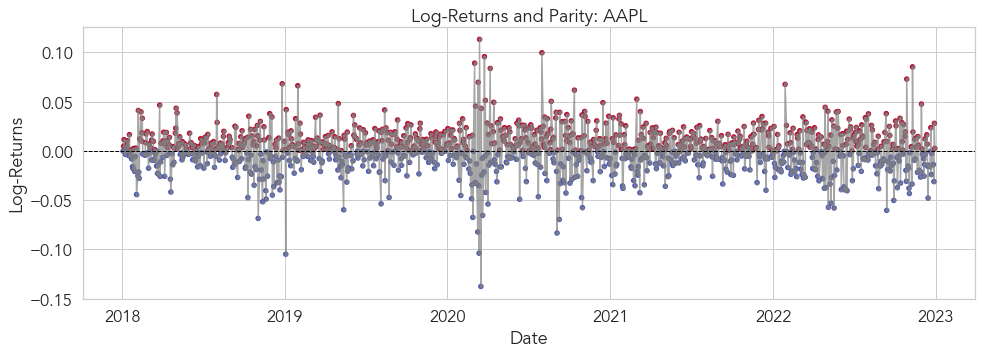

In [5]:
sample_ticker = 'AAPL'
# data = pd.read_csv(os.path.join(DATA_DIR, f'{sample_ticker}.csv'), index_col=0, parse_dates=True)
data = ec.data.stock_parity.compute_log_returns_and_parity(sample_ticker, start=START_DATE, end=END_DATE, save_dir=DATA_DIR)
_ = ec.data.stock_parity.plot_log_returns_and_parity(data, sample_ticker, None)

In [6]:
# pairwise difference squared
data["VolSq"] = (data["Price"] - data["Price"].shift(1)) ** 2
data["HighVol"] = data["VolSq"] > data["VolSq"].quantile(0.8)
data["HighVol"].value_counts()

False    1007
True      252
Name: HighVol, dtype: int64

In [7]:
# HPARAMS
methods = ["UI", "Conformal"]
methods_kwargs = [None, dict(jump=0.01, jumper_weights=(1/3, 1/3, 1/3))]
needs_adj = [False, True]
adjuster_kwargs = [None, dict(use_maximum=False)]
test_volatility = True

colors = [ec.PLOT_DEFAULT_COLORS[i] for i in [0, 3, 2]]  # switch out conformal (yellow) with adjusted conformal (orange)
style_order = ["Combined", "UI", "Conformal (Adj.)"]

### Parity Exchangeability

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


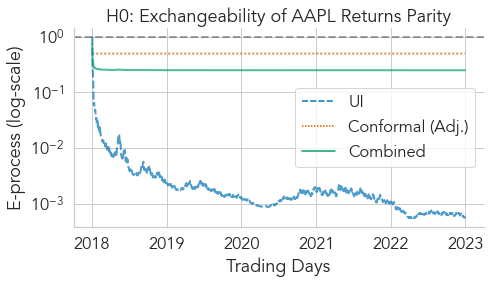

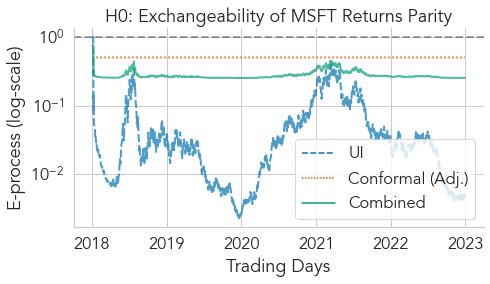

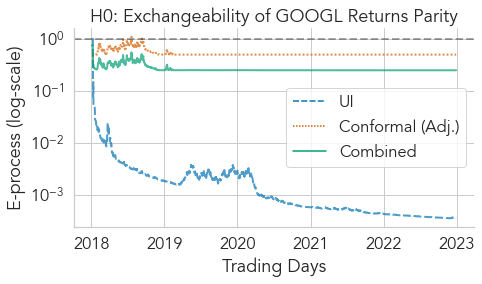

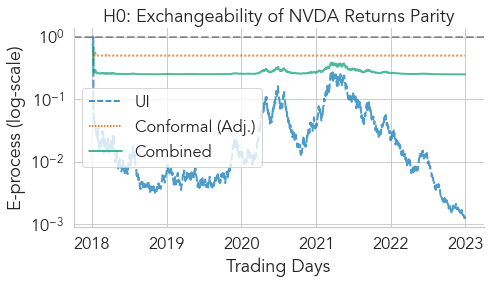

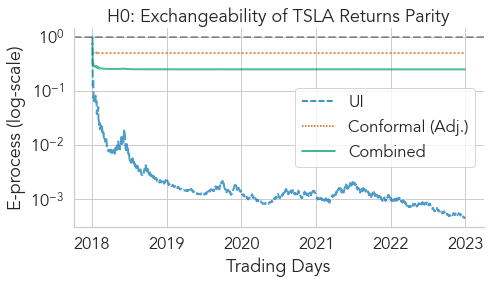

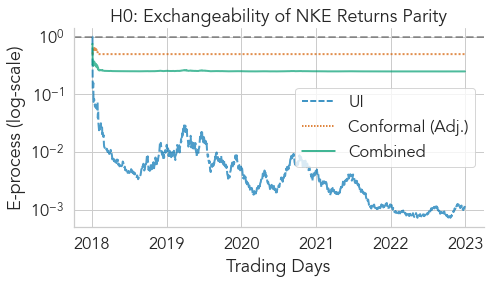

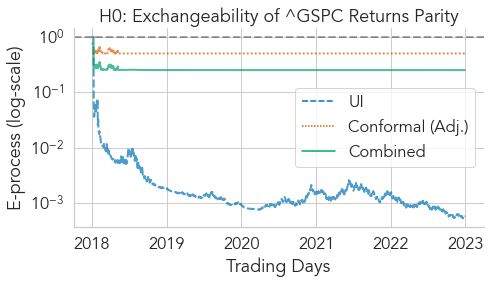

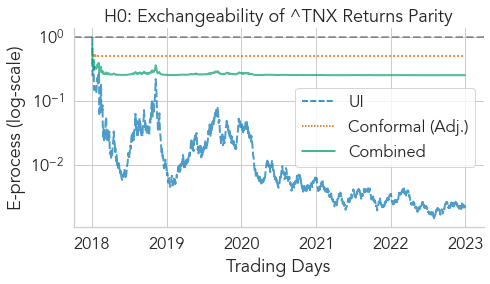

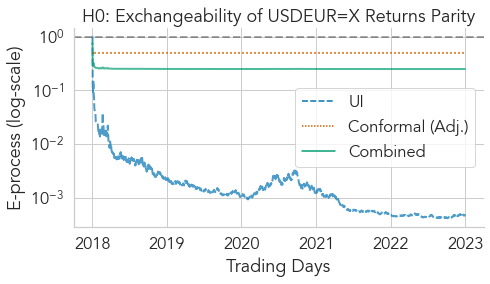

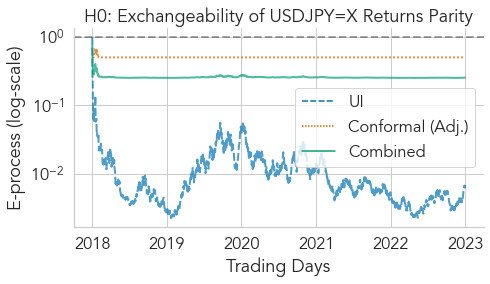

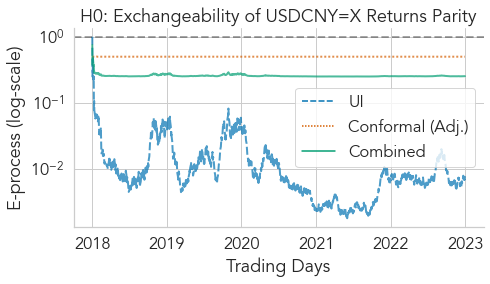

In [8]:
for ticker in tickers:
    # data = pd.read_csv(os.path.join(DATA_DIR, f'{ticker}.csv'), index_col=0, parse_dates=True)
    data = ec.data.stock_parity.compute_log_returns_and_parity(ticker, start=START_DATE, end=END_DATE, save_dir=DATA_DIR)
    eprocesses_dict, x_df = ec.combined_exch_eprocesses(
        data, 
        methods=methods,
        methods_kwargs=methods_kwargs,
        needs_adj=needs_adj,
        adjuster_kwargs=adjuster_kwargs,
        data_col="Parity",
        rng=rng,
        return_df=False,
        )
    e_labels, e_list = zip(*eprocesses_dict.items())
    fg = ec.plot_eprocess(
        e_list, e_labels, time_index=x_df.index, 
        palette=colors, style_order=style_order, facet_kws=dict(legend_out=False),
        height=4, aspect=1.75,
        title=f"H0: Exchangeability of {ticker} Returns Parity",
        )
    fg.ax.set_xlabel("Trading Days")
    fg._legend.set_title(None)
    fg.savefig(os.path.join(plots_dir, f"EProcessParity{ticker}.pdf"))
    fg.savefig(os.path.join(plots_dir, f"EProcessParity{ticker}.png"), dpi=350)

### Exchangeability of High-Volatility Days

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


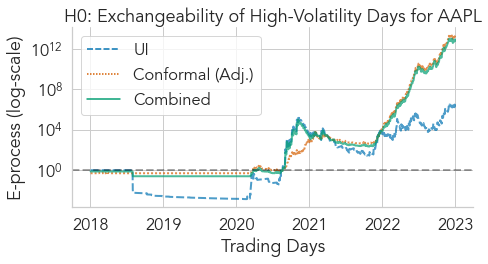

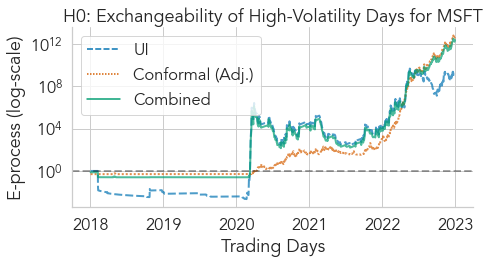

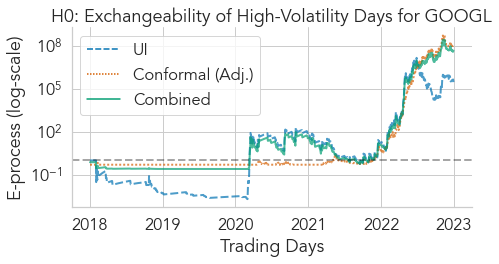

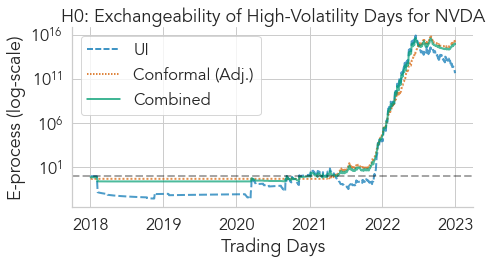

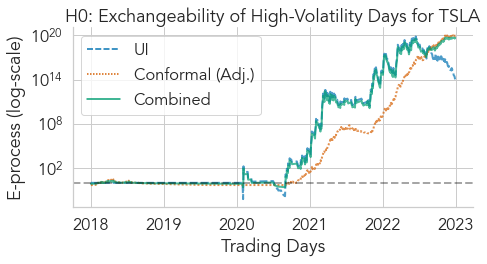

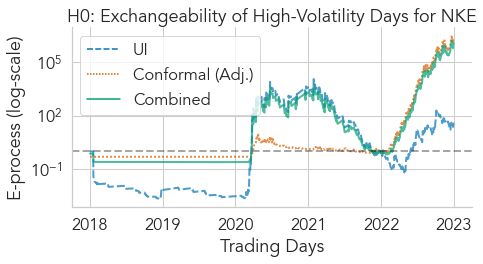

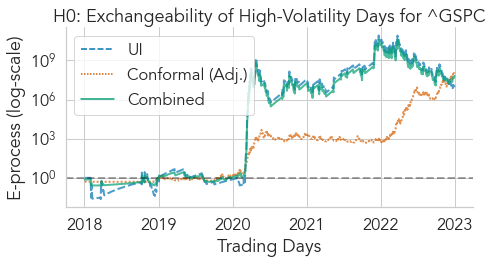

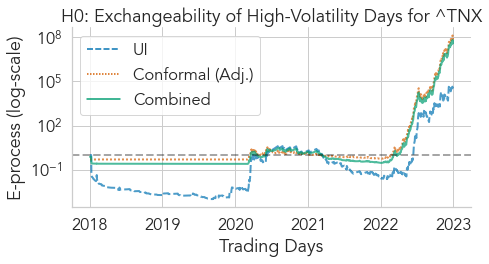

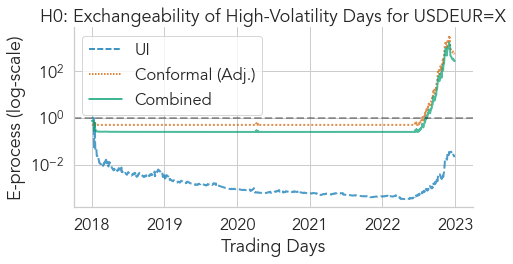

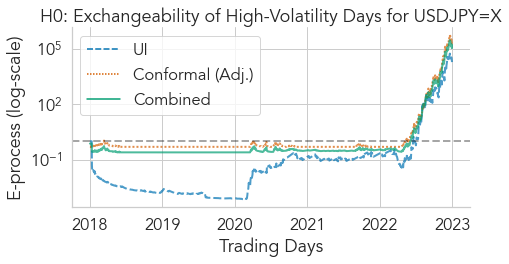

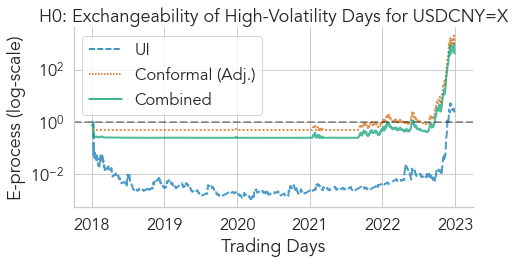

In [9]:
THRESHOLD = 0.8
for ticker in tickers:
    # data = pd.read_csv(os.path.join(DATA_DIR, f'{ticker}.csv'), index_col=0, parse_dates=True)
    data = ec.data.stock_parity.compute_log_returns_and_parity(ticker, start=START_DATE, end=END_DATE, save_dir=DATA_DIR)
    # for volatility test
    data["VolSq"] = (data["Price"] - data["Price"].shift(1)) ** 2
    data["HighVol"] = data["VolSq"] > data["VolSq"].quantile(THRESHOLD)

    eprocesses_dict, x_df = ec.combined_exch_eprocesses(
        data, 
        methods=methods,
        methods_kwargs=methods_kwargs,
        needs_adj=needs_adj,
        adjuster_kwargs=adjuster_kwargs,
        data_col="HighVol",
        rng=rng,
        return_df=False,
        )
    e_labels, e_list = zip(*eprocesses_dict.items())
    fg = ec.plot_eprocess(
        e_list, e_labels, time_index=x_df.index, 
        palette=colors, style_order=style_order, facet_kws=dict(legend_out=False),
        height=4, aspect=1.75, 
        title=f"H0: Exchangeability of High-Volatility Days for {ticker}",
    )
    fg.ax.set_xlabel("Trading Days")
    # remove legend title
    fg._legend.set_title(None)
    fg.tight_layout()
    fg.savefig(os.path.join(plots_dir, f"EProcessHighVolatility{ticker}.pdf"))
    fg.savefig(os.path.join(plots_dir, f"EProcessHighVolatility{ticker}.png"), dpi=350)